<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C11_B_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from typing import Any, ForwardRef, Tuple

A BTreeNode class is used to represent a node in a B-Tree (Balanced Tree) structure. Each node can hold between k and 2k values and can have between k+1 and 2k+1 children nodes. The exception is the root node which has between 0 and 2k values. A children at position i contains values that are between the key at position i and the key at position i+1.

The class has methods for:
*   Search
*   Adding a new key value
*   Deleting a key value

In addition to those helper methods have been added for:
*   indicating if a node is under-full or over-full
*   finding the next minimum value (useful on delete)
*   to split a node (useful for fixing over-full nodes)
*   to repair a under-full node by merging two sibling nodes (if the total is below 2k) or transfering left/right (if the total would exceed 2k)



In [18]:
class BTreeNode:
    def __init__(self, k: int):
        self.k = k
        self.size = 0
        self.is_leaf = True
        # Both keys and children use one extra storage so accomodate an insert
        # that might overspill the node prior to splitting (see insert function).
        self.keys = [None] * (2 * k + 1)
        self.children = [None] * (2 * k + 2)

    def BTreeNodeSearch(self, target: Any) -> Any:
        # Search the node's key list for the target.
        # For simplicity sake we use a linear search, but a binary search is
        # a good option as well.
        i = 0
        while i < self.size and target >= self.keys[i]:
            # Check if we found a matching key in the current node.
            if target == self.keys[i]:
                return self.keys[i]
            i += 1

        # If we didn't find a match then descend to the correct child.
        if self.is_leaf:
            # Current node is a leaf then there's no match in the tree.
            return None
        return self.children[i].BTreeNodeSearch(target)

    def BtreeNodeAddKey(self, key: Any, next_child: ForwardRef('BTreeNode')) -> None:
        '''
        Helper function to insert a key into a non-full node.
        <next_child> is a pointer to the child node (the child after the new key).
        For a leaf node the next_child pointer is ignored.
        '''
        # Start at the end of the keys array and move towards 0.
        # At each step check if the new key should be inserted here
        # and if not shift the elements of keys and children back one position.
        i = self.size - 1
        while i >= 0 and key < self.keys[i]:
            self.keys[i + 1] = self.keys[i]
            if not self.is_leaf:
                self.children[i + 2] = self.children[i + 1]
            i -= 1

        # Insert both the key and the pointer to the child node.
        # By this time we have already shifted the following elements.
        self.keys[i + 1] = key
        if not self.is_leaf:
            self.children[i + 2] = next_child
        # Adjust the size of the node with the new insertion.
        self.size += 1

    def BTreeNodeIsOverFull(self) -> bool:
        '''
        Helper function to indicate if the node goes beyond the limit of 2k items.
        '''
        return self.size == (2 * self.k + 1)

    def BTreeNodeIsUnderFull(self) -> bool:
        '''
        Helper function to indicate if the node goes below the limit of k items.
        '''
        return self.size < self.k

    def BTreeNodeSplit(self, child_index: int) -> None:
        '''
        Helper function that takes the index of a child of the node and splits
        that child. Everything before that index is retained in the original
        child. Everythign after that index is cleared from the child and added
        to a newly created child node. The key at the index itself is cleared
        from the child and added to the current (parent) node.
        '''
        # old_child is the node to split, new_child is the new empty sibling node.
        # The new node is at the same level as old_child so copy is_leaf.
        old_child = self.children[child_index]
        new_child = BTreeNode(self.k)
        new_child.is_leaf = old_child.is_leaf

        # Get the index and key used for the split point for old_child.
        split_index = int(old_child.size / 2)
        split_key = old_child.keys[split_index]

        # Copy the larger half of the keys (and their children) to new_child and erase them from old_child.
        new_index = 0
        old_index = split_index + 1
        while old_index < old_child.size:
            new_child.keys[new_index] = old_child.keys[old_index]
            old_child.keys[old_index] = None

            if not old_child.is_leaf:
                new_child.children[new_index] = old_child.children[old_index]
                old_child.children[old_index] = None
            new_index += 1
            old_index += 1

        # Copy the remainining child (after the last key).
        # This needs to be done since the children array is one element longer.
        if not old_child.is_leaf:
            new_child.children[new_index] = old_child.children[old_child.size]
            old_child.children[old_child.size] = None

        # Remove the key at index and add it to the current node.
        old_child.keys[split_index] = None
        self.BtreeNodeAddKey(split_key, new_child)

        # Update the sizes of the nodes.
        new_child.size = old_child.size - split_index - 1
        old_child.size = split_index

    def BTreeNodeInsert(self, key: Any) -> None:
        '''
        Insertion function. The addition is done at leaf level then recursively
        return up the tree checking if the recently accessed child node is full
        and it needs to be split.
        '''
        # First figure out the correct location for key in the keys array.
        i = 0
        while i < self.size and key >= self.keys[i]:
            if key == self.keys[i]:
                # Here we can update the data for this key
                return
            i += 1

        if self.is_leaf:
            # If the node is a leaf then just add the key (and shift the elements)
            self.BtreeNodeAddKey(key, None)
        else:
            # Recursively insert into the child nodes
            self.children[i].BTreeNodeInsert(key)
            # Check if we insert too many elements and split the overfull child at the parent.
            if self.children[i].BTreeNodeIsOverFull():
                self.BTreeNodeSplit(i)

    def BTreeNodeMerge(self, index: int) -> None:
        '''
        The merge function takes two sibling nodes (based on index)
        together with the key separating them and combines them into a single
        larger node. The larger node combined keys need to be less than 2k.
        '''
        # Start by retrieving both child nodes (left and right).
        # All keys from the right child and the index key from the parent
        # will be appended to the left child.
        childL = self.children[index]
        childR = self.children[index + 1]

        # Copy over the parent's key and the right child's first child pointer.
        # All keys in childL are less than the index key in parent.
        loc = childL.size
        childL.keys[loc] = self.keys[index]
        if not childL.is_leaf:
            childL.children[loc + 1] = childR.children[0]
        loc += 1

        # Copy over the right child's keys and children to the left child.
        # All keys in childR are greater than the index key in the parent.
        for i in range(childR.size):
            childL.keys[loc + i] = childR.keys[i]
            if not childL.is_leaf:
                childL.children[loc + i + 1] = childR.children[i + 1]
        childL.size += childR.size + 1

        # Remove the key from the parent node by shifting the keys after index
        # and pointers, setting the final ones to None and updating the size.
        for i in range(index, self.size - 1):
            self.keys[i] = self.keys[i + 1]
            self.children[i + 1] = self.children[i + 2]

        self.keys[self.size - 1] = None
        self.children[self.size] = None
        self.size -= 1

    def BTreeNodeTransferLeft(self, index: int) -> None:
        '''
        Helper function to transfer a key from the right child to the left child
        based on the parent key at index position.
        '''
        # Retrieve the two sibling child nodes and the separating key.
        childL = self.children[index]
        childR = self.children[index + 1]
        middle_key = self.keys[index]

        # Move the first key from right to parent (replaces the previous middle_key).
        self.keys[index] = childR.keys[0]
        # Add the previous separating key from parent and the first child from right
        # at the end of the arrays of the left child.
        childL.keys[childL.size] = middle_key
        if not childR.is_leaf:
            childL.children[childL.size + 1] = childR.children[0]
        childL.size += 1

        # Cleans up the right child by shifting over the remaining elements.
        for i in range(childR.size - 1):
            childR.keys[i] = childR.keys[i + 1]
            if not childR.is_leaf:
                childR.children[i] = childR.children[i + 1]

        # Then marks the empty spots as None
        childR.keys[childR.size - 1] = None
        if not childR.is_leaf:
            childR.children[childR.size - 1] = childR.children[childR.size]
            childR.children[childR.size] = None
        # At the end adjust the size.
        childR.size -= 1

    def BTreeNodeTransferRight(self, index: int) -> None:
        '''
        Helper function to transfer a key from a left child to a right child
        based on the parent key at index position.
        '''
        # Retrieves the two sibling childs and the separating key.
        childL = self.children[index]
        childR = self.children[index + 1]
        middle_key = self.keys[index]

        # Make space in childR for the new key and pointer.
        for i in range(childR.size - 1, -1, -1):
            childR.keys[i + 1] = childR.keys[i]
            if not childR.is_leaf:
                childR.children[i + 2] = childR.children[i + 1]
        if not childR.is_leaf:
            childR.children[1] = childR.children[0]

        # Appends the previous separating key from the parent and the last
        # child pointer from left to the beginning of the right child.
        childR.keys[0] = middle_key
        if not childR.is_leaf:
            childR.children[0] = childL.children[childL.size]
        childR.size += 1

        # Moves the last key in the left child to the parent replacing the
        # previous separating key.
        self.keys[index] = childL.keys[childL.size - 1]

        # Cleans up the left child by marking the now empty entries with None
        # and adjusting the size.
        childL.keys[childL.size - 1] = None
        if not childL.is_leaf:
            childL.children[childL.size] = None
        childL.size -= 1

    def BTreeNodeRepairUnderFull(self, child: int) -> None:
        '''
        Helper function to repair a under-full child of the current node.
        It encapsulates the previous transfer functions chosen based on the two
        children's total number of keys.
        '''
        # We use a simplistic approach of always using the next child (child+1)
        # unless we are repairing the last child. If we are repairing the last
        # child then use the previous child for its sibling.
        if child == self.size:
            child -= 1
        # Check the total count of keys in the two child nodes.
        total = self.children[child].size + self.children[child + 1].size

        # If the total is small enough (under 2k) then just merge the nodes.
        if total < 2 * self.k:
            self.BTreeNodeMerge(child)
            return

        # If total is 2k or more then move a single key to the smaller node.
        if self.children[child].size < self.children[child + 1].size:
            self.BTreeNodeTransferLeft(child)
        else:
            self.BTreeNodeTransferRight(child)

    def BTreeNodeFindMin(self) -> Any:
        '''
        Helper function to find and return the minimum key at or below a given node.
        '''
        # If the node is empty then there is no minimum key here so return None.
        # This can only happen in an empty root node.
        if self.size == 0:
            return None
        # If the node is a leaf then return the first key (it's the minimum).
        if self.is_leaf:
            return self.keys[0]
        else:
            # If the node is internal then recursively check the first child.
            return self.children[0].BTreeNodeFindMin()

    def BTreeNodeDelete(self, key: Any) -> None:
        '''
        Function to remove a particular key by recursively descending the tree.
        If the number of keys is reduced below the minimum k, then the under-full
        child needs to be repaired.
        '''
        # Search for the key to delete in the current node.
        # The while loop will terminate when i is the index matching the key.
        i = 0
        while i < self.size and key > self.keys[i]:
            i += 1

        # Deletion from a leaf node.
        if self.is_leaf:
            if i < self.size and key == self.keys[i]:
                # Deletion is done by shifting over the keys.
                while i < self.size - 1:
                    self.keys[i] = self.keys[i + 1]
                    i += 1
                # The last element is set to None and size is updated.
                self.keys[i] = None
                self.size -= 1
            # If the key is not found and node is a leaf the code just returns.
            return

        # Deletion at an internal node.
        # First case: the key is found in the node.
        if i < self.size and key == self.keys[i]:
            # It needs to replace the key with the key that immediately follows
            # the target key in sorted order.
            min_key = self.children[i + 1].BTreeNodeFindMin()
            self.keys[i] = min_key

            # Then delete this following key from the child subtree and fix the
            # child if needed.
            self.children[i + 1].BTreeNodeDelete(min_key)
            if self.children[i + 1].BTreeNodeIsUnderFull():
                self.BTreeNodeRepairUnderFull(i + 1)
        else:
            # Second case: target key is not in the internal node so
            # recursively call the function on the appropriate child and fix it.
            self.children[i].BTreeNodeDelete(key)
            if self.children[i].BTreeNodeIsUnderFull():
                self.BTreeNodeRepairUnderFull(i)


A BTree class to represent a B-Tree. Each B-Tree has a root node and a minimum k size applicable to all nodes in that tree.

In [19]:
class BTree:
    def __init__(self, k: int):
        self.k = k
        self.root = BTreeNode(k)

    def BTreeSearch(self, target: Any) -> Any:
        return self.root.BTreeNodeSearch(target)

    def BTreeInsert(self, key: Any) -> None:
        '''
        Insert a new key in the BTree and handle the special case for the root
        node (splitting the rood node = increase the height of the tree).
        '''
        # Start by inserting the key into the root node. This will recursively
        # descend the tree, insert the key in the right location then return
        # and fix all nodes except the root.
        self.root.BTreeNodeInsert(key)

        # Check if the root node has too many elements.
        if self.root.BTreeNodeIsOverFull():
            # We add a new level by creating a new root node.
            new_root = BTreeNode(self.k)
            new_root.is_leaf = False
            new_root.size = 0

            # Old root is a child of the new root which is then split.
            # After the split the new root will have exactly one key and two children.
            new_root.children[0] = self.root
            new_root.BTreeNodeSplit(0)
            self.root = new_root

    def BTreeDelete(self, key: Any) -> Any:
        '''
        Delete function for a target key. It recursively calls the delete
        function using the root node.
        '''
        self.root.BTreeNodeDelete(key)

        # If the root becomes empty then remove a level from the tree.
        if self.root.size == 0 and not self.root.is_leaf:
            self.root = self.root.children[0]

Some utility function to be able to draw a btree representation using graphviz.
The function will draw each node as a set of records with children pointers (represented as a * character) interlaced with key values.

In [20]:
import graphviz
from graphviz import nohtml

def visualize_btree(btree: BTree) -> graphviz.Digraph:
    dot = graphviz.Digraph(node_attr={'shape':'record', 'height':'.1'})

    def generate_node(node: BTreeNode) -> Tuple[str, str]:
        name = []
        content = []
        for i, key in enumerate(node.keys):
            # Put a * cell for a children node pointer.
            if node.children[i] != None:
                content.append(f'<f{i}> *|')
            # Put a cell with the key value.
            if key != None:
                name.append(str(key))
                content.append(f' {str(key)}|')
            # Make sure to remove the last empty cell (don't put a | at the end).
            if i == len(node.keys) - 1 and node.children[-1] == None:
                content[-1] = content[-1][:-1]
        if node.children[-1] != None:
            content.append(f'<f{len(node.children) - 1}> *')
        return (''.join(name), ''.join(content))

    def visualize_btreenode(node: BTreeNode, dot: graphviz.Digraph) -> str:
        name, content = generate_node(node)
        dot.node(name, nohtml(content))

        for i, child in enumerate(node.children):
            if child != None:
                child_name = visualize_btreenode(child, dot)
                dot.edge(f'{name}:f{i}', f'{child_name}')
        return name

    visualize_btreenode(btree.root, dot)

    return dot

Some example of building a BTree. At the end we display it.

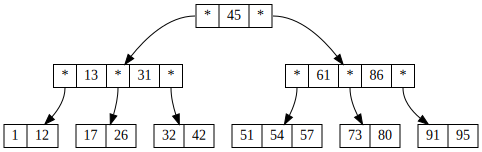

In [21]:
btree = BTree(2)
keys = [1, 12, 13, 17, 31, 45, 32, 26, 42, 61, 54, 57, 91, 86, 95, 73, 80, 51]
for key in keys:
    btree.BTreeInsert(key)

visualize_btree(btree)

Then add one more key and see the tree again. Notice how the key is added to the leaf node as there's still room.

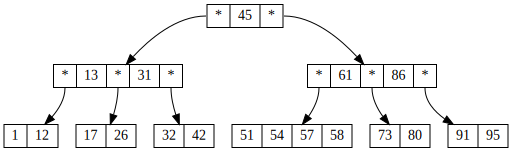

In [22]:
btree.BTreeInsert(58)
visualize_btree(btree)

Now we add one more key, the leaf node will be beyond capacity so we end up splitting it.

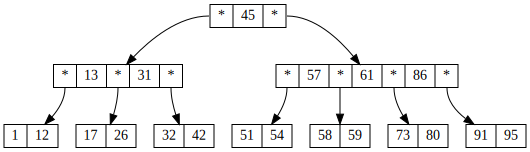

In [23]:
btree.BTreeInsert(59)
visualize_btree(btree)

We add more nodes and display it.

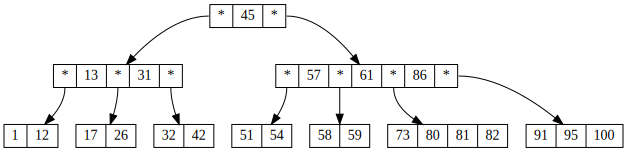

In [24]:
btree.BTreeInsert(100)
btree.BTreeInsert(81)
btree.BTreeInsert(82)
visualize_btree(btree)

Remove a key from a leaf node with enough keys to not be underfull

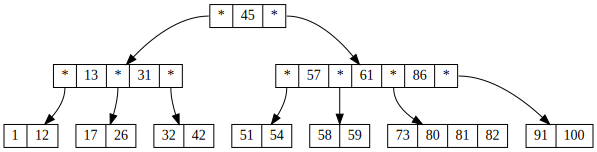

In [25]:
btree.BTreeDelete(95)
visualize_btree(btree)

Remove a key from an internal node (86) and see the child key replacing it.

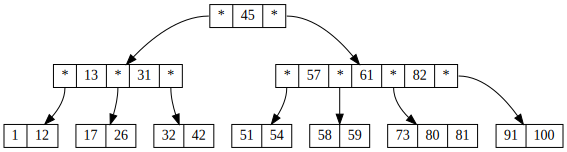

In [26]:
btree.BTreeDelete(86)
visualize_btree(btree)

In [27]:
print(btree.root.children[1].keys)
print(btree.root.children[1].children[0].keys)

[57, 61, 82, None, None]
[51, 54, None, None, None]


Now let's remove 51, this will cause its child node to be under-full so it needs to be repaired (a merge with its sibling together with the 57 key from the parent).

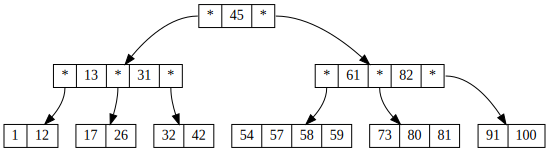

In [28]:
btree.BTreeDelete(51)
visualize_btree(btree)

Now let's remove 91.

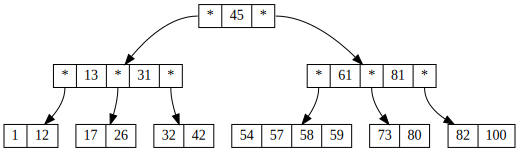

In [29]:
btree.BTreeDelete(91)
visualize_btree(btree)

Now let's remove the value of the root. The next value will replace it.

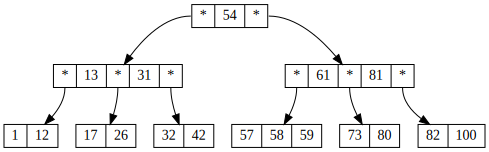

In [30]:
btree.BTreeDelete(45)
visualize_btree(btree)

Let's remove the root value again. Again the next value will replace it. That child now has the minimum numeber of values.

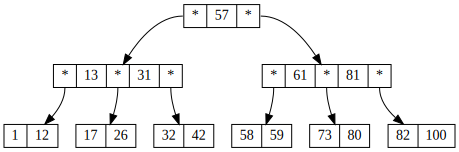

In [31]:
btree.BTreeDelete(54)
visualize_btree(btree)

Let's remove the root value again. The next value that should replace it is 58, but that child node will become under-full so it will merge the siblings (59 + 61 from the parent + 73 and 80), causing the parent to become underfull (only 81) at it's turn and fixing it will end up merging with the left sibling and the root value. The root now is 0 size so one level is removed.

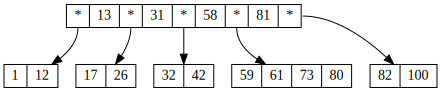

In [32]:
btree.BTreeDelete(57)
visualize_btree(btree)